In [10]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR # for building SVR model
import scipy
import catboost as cb
from LocalRegression.bmlr import BMLR
from sklearn.metrics import mean_squared_error

In [3]:
def generate_tpf(n=100, sigma=0.1, dgp=ss.uniform()):
    norm = ss.norm(loc=0, scale=sigma)
    x = dgp.rvs(n)
    def tpf_(t):
        if t<0.3: return 2*t
        if t>0.7: return 1.4-t # perhaps 1.3-t?
        return 0.6
    y = list(map(tpf_, x))
    y += norm.rvs(n)
    return x, y

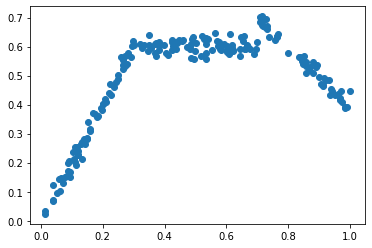

In [4]:
x, y = generate_tpf(n=200, sigma=0.02)
plt.plot(x, y, 'o')

In [4]:
def rmse_ols(n, sigma, mcloops=1000, dgp=ss.uniform()):
    rmses = []
    for mcloop in range(mcloops):
        x, y = generate_tpf(n=n, sigma=sigma, dgp=dgp)
        X = x.reshape(-1,1)
        lm = LinearRegression().fit(X,y)
        rmse = mean_squared_error(lm.predict(X), y, squared=False)
        rmses.append(rmse)
    return np.mean(rmses) 

In [5]:
sigmas = [0.02, 0.2, 0.5]
ns = [200, 500, 1000, 2000]
mcloops = 1000
rmses = []
for sigma in sigmas:
    for n in ns:
        rmses.append([sigma, n, rmse_ols(n=n, sigma=sigma, mcloops=mcloops, dgp=ss.norm())])

In [6]:
pd.DataFrame(rmses, columns=['sigma', 'n', 'OLS'])

,sigma,n,OLS
0,0.02,200,0.792416
1,0.02,500,0.802536
2,0.02,1000,0.802873
3,0.02,2000,0.804893
4,0.20,200,0.819210
5,0.20,500,0.823933
6,0.20,1000,0.828521
7,0.20,2000,0.829094
8,0.50,200,0.936375
9,0.50,500,0.942805


In [5]:
# some test
x, y = generate_tpf(n=200, sigma=0.02)
x_test, y_test = generate_tpf(n=40, sigma=0.02)
x = x.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [6]:
bmlr = BMLR(cut=5, M=20, substitution_policy='global')
bmlr.fit(x,y)
print(bmlr.score(x, y))

1
0.12590332504952662


In [16]:
mcloops = 10
cut = 25
M = 20
dgp = ss.norm()

rmses = []
epsilon_list = np.linspace(0.2, 2, 10)
for epsilon in epsilon_list:
    print(f'epsilon={epsilon}')
    rmses_epsilon = []
    for mcloop in range(mcloops): 
        x_train, y_train = generate_tpf(n=200, sigma=0.02, dgp=dgp)
        x_test, y_test = generate_tpf(n=40, sigma=0.02, dgp=dgp)
        x_train = x_train.reshape(-1,1)
        x_test = x_test.reshape(-1,1)

        bmlrg = BMLR(cut=cut, M=M, substitution_policy='global')
        bmlrn = BMLR(cut=cut, M=M, substitution_policy='nearest')
        bmlrg.fit(x_train, y_train, epsilon=epsilon)
        bmlrn.fit(x_train, y_train, epsilon=epsilon)

        rmseg_in  = bmlrg.score(x_train, y_train)
        rmseg_out = bmlrg.score(x_test, y_test)
        rmsen_in  = bmlrn.score(x_train, y_train)
        rmsen_out = bmlrn.score(x_test, y_test)
        
        # train catboost
        train_dataset = cb.Pool(x_train, y_train)
        test_dataset = cb.Pool(x_test, y_test)
        model = cb.CatBoostRegressor(loss_function='RMSE')
        model.fit(train_dataset, eval_set=test_dataset, use_best_model=True, verbose=0)
        cb_score = model.best_score_['validation']['RMSE']
        
        rmses_epsilon.append([rmseg_in, rmsen_in, rmseg_out, rmsen_out, cb_score])
    
    rmses_epsilon = np.mean(rmses_epsilon, axis=0)
    rmses.append([epsilon, *rmses_epsilon])

epsilon=0.2
epsilon=0.4
epsilon=0.6000000000000001
epsilon=0.8
epsilon=1.0
epsilon=1.2
epsilon=1.4000000000000001
epsilon=1.6
epsilon=1.8
epsilon=2.0


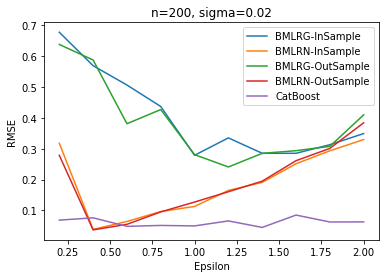

In [17]:
rmses = np.array(rmses)
plt.plot(rmses[:, 0], rmses[:, 1], label='BMLRG-InSample')
plt.plot(rmses[:, 0], rmses[:, 2], label='BMLRN-InSample')
plt.plot(rmses[:, 0], rmses[:, 3], label='BMLRG-OutSample')
plt.plot(rmses[:, 0], rmses[:, 4], label='BMLRN-OutSample')
plt.plot(rmses[:, 0], rmses[:, 5], label='CatBoost')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')
plt.title('n=200, sigma=0.02')
plt.legend()

In [7]:
# make some plots
cut = 25
M = 20
xt = np.linspace(0, 1, 100)
xt = np.array(xt).reshape((-1,1))
X, y = generate_tpf(n=200, sigma=0.02)
X = X.reshape((-1,1))

bmlrg = BMLR(cut=cut, M=M, substitution_policy='global')
bmlrn = BMLR(cut=cut, M=M, substitution_policy='nearest')
bmlrg.fit(X, y, epsilon=0.12)
bmlrn.fit(X, y, epsilon=0.12)

yg = bmlrg.predict(xt)
yn = bmlrn.predict(xt)
plt.plot(X, y, 'o', markersize=3, color='black')
plt.plot(xt, yg, label='BMLRG', color='red')
plt.plot(xt, yn, label='BMLRN', color='blue')

TypeError: fit() got an unexpected keyword argument 'epsilon'

# Test model using 3d hyperplane (no noise)
Coefficiants in each ball should be the same and have the same values as in data generating process 

In [8]:
def generate_plane(n=100):
    x = ss.uniform.rvs(size=(n,3))
    y = x[:, 0]*0.34 + x[:, 1]*0.11 + x[:, 2]*(-1.234) + 0.8
    return x, y

In [9]:
sample_x, sample_y = generate_plane(2000)
bmlrn_hyperplane = BMLR(cut=5, M=1, substitution_policy='nearest')
bmlrn_hyperplane.fit(sample_x, sample_y, epsilon=0.2)
score = bmlrn_hyperplane.score(sample_x, sample_y)
print(score) # this should be close to 0

TypeError: fit() got an unexpected keyword argument 'epsilon'

In [22]:
# coefficients here should be the same as in generate
print(bmlrn_hyperplane.ball_mappers[0].Graph.nodes[3]['beta'])
print(bmlrn_hyperplane.ball_mappers[0].Graph.nodes[3]['intercept'])

[ 0.34   0.11  -1.234]
0.8000000000000003


# Test model using multimodal functions
We study functions typically used to test optimization problems.
Here we go with [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function)

In [2]:
def generate_Himmelblau(n=100, sigma=0.1):
    norm = ss.norm(loc=0, scale=sigma)
    x = (ss.uniform.rvs(size=(n, 2))-0.5)*5*2
    y = (x[:, 0]**2 + x[:, 1] - 11)**2 + (x[:, 0] + x[:, 1]**2 - 7)**2
    y += norm.rvs(n)
    return x, y

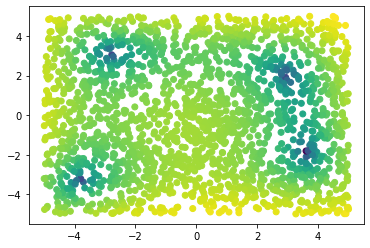

In [3]:
sample_x, sample_y = generate_Himmelblau(n=2000)
sample_x_test, sample_y_test = generate_Himmelblau(n=500)
plt.scatter(sample_x[:, 0], sample_x[:, 1], c=np.log(sample_y))

In [4]:
from sklearn.model_selection import GridSearchCV
# from sklearn.utils.fixes import loguniform

In [14]:
def model_random_forest(x, y, x_test, y_test):
    param_grid = {'n_estimators': [10, 100, 1000, 2500, 3000]}
    rf = RandomForestRegressor()
    sh = GridSearchCV(rf, param_grid, cv=3).fit(x, y)
    pred = sh.predict(x_test)
    score = mean_squared_error(pred, y_test, squared=False)
    return score, pred

def model_catboost(x, y, x_test, y_test):
    train_dataset = cb.Pool(x, y)
    test_dataset = cb.Pool(x_test, y_test)
    model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
    model.fit(train_dataset)
    pred = model.predict(test_dataset)
    score = mean_squared_error(pred, y_test, squared=False)
    return score, pred

In [8]:
def model_mars():
    pass

def model_svr(x, y, x_test, y_test):
    param_grid = {'C': [0.1, 1, 100, 1000, 1000],
                  'degree': [2],
                  'epsilon': [0.01, 0.1, 1, 10]
                 }
    svr = SVR(kernel='rbf')
    #sh = HalvingGridSearchCV(model, param_grid, cv=5, factor=3, max_resources=50, n_jobs=-1).fit(x, y)
    #sh = RandomizedSearchCV(model, param_grid, cv=5).fit(x, y)
    sh = GridSearchCV(svr, param_grid, cv=3, verbose=1).fit(x, y)
    print(sh.best_params_)
    pred = sh.predict(x_test)
    score = mean_squared_error(pred, y_test, squared=False)
    return score, pred

def model_bmlr(x, y, x_test, y_test):
    epsilon_trial = np.mean(np.std(sample_x, axis=0))/5
    param_grid = {'epsilon': [epsilon_trial*x for x in [0.2, 0.5, 0.8, 1.0, 1.5, 2.0]]}
    bmlr = BMLR(cut=10, M=5, substitution_policy='nearest')
    gsh = GridSearchCV(bmlr, param_grid, cv=3, verbose=1)
    sh = gsh.fit(x, y)
    print(sh.best_params_)
    pred = sh.predict(x_test)
    score = mean_squared_error(pred, y_test, squared=False)
    return score, pred, gsh

In [ ]:
rf_score, rf_pred = model_random_forest(sample_x, sample_y, sample_x_test, sample_y_test)

In [84]:
cb_score, cb_pred = model_catboost(sample_x, sample_y, sample_x_test, sample_y_test)

In [87]:
svr_score, svr_pred = model_svr(sample_x, sample_y, sample_x_test, sample_y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'C': 1000, 'degree': 2, 'epsilon': 0.1}


In [89]:
rf_score

12.1904767417316

In [90]:
cb_score

4.55880341408578

In [91]:
svr_score

4.057335688923438

In [11]:
bmlr_score, bmlr_pred, bmlr_sh = model_bmlr(sample_x, sample_y, sample_x_test, sample_y_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0.11417204704297523
0.11417204704297523
0.11417204704297523
0.2854301176074381
0.2854301176074381
0.2854301176074381
0.45668818817190093
0.45668818817190093
0.45668818817190093
0.5708602352148762
0.5708602352148762
0.5708602352148762
0.8562903528223142
0.8562903528223142
0.8562903528223142
1.1417204704297523
1.1417204704297523
1.1417204704297523


/home/rafal/WORK/IMPAN/LocalRegression/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/rafal/WORK/IMPAN/LocalRegression/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/rafal/WORK/IMPAN/LocalRegression/notebooks/LocalRegression/bmlr.py", line 46, in fit
    return self.__fit__(x=x, y=y, epsilon=self.epsilon, M=self.M)
  File "/home/rafal/WORK/IMPAN/LocalRegression/notebooks/LocalRegression/bmlr.py", line 9

1.1417204704297523
{'epsilon': 1.1417204704297523}


In [ ]:
# test various epsilons. This is quite good accually - we get result better than Random Forrest and CatBoost
for epsilon in np.linspace(0.3, 2, 10):
    bmlrn_himmmel = BMLR(cut=10, M=10, substitution_policy='nearest')
    bmlrn_himmmel.fit(sample_x, sample_y, epsilon=epsilon)
    bmlrn_himmmel_score = bmlrn_himmmel.score(sample_x_test, sample_y_test)
    print(f'epsilon={epsilon} rmse={bmlrn_himmmel_score}')

# Multidiemntional data
TODO

# Train on Boston dataset

In [33]:
# Test model on some real data and benchmark it against catboost
boston_dataset = load_boston()

In [34]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [35]:
# get rid of data with too constant values, for simplicity of too high variance
X = boston.drop(['ZN', 'CHAS', 'RAD', 'TAX', 'B'], axis=1)
y = boston_dataset.target

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train_dataset = cb.Pool(X_train, y_train)
# test_dataset = cb.Pool(X_test, y_test)

# model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
# model.fit(train_dataset)
# pred = model.predict(X_test)
# cb_score = mean_squared_error(pred, y_test, squared=False)
# print(cb_score)

In [37]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train_scaled, y_train)
pred = rf.predict(X_test_scaled)
rf_score = mean_squared_error(pred, y_test, squared=False)
print(rf_score)

3.092882059443485


In [38]:
train_dataset = cb.Pool(X_train_scaled, y_train)
test_dataset = cb.Pool(X_test_scaled, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0)
model.fit(train_dataset)
pred = model.predict(test_dataset)
cb_score = mean_squared_error(pred, y_test, squared=False)
print(cb_score)

2.847076228540886


In [41]:
bmlrn_boston = BMLR(cut=10, M=1, substitution_policy='nearest')
bmlrn_boston.fit(X_train_scaled, y_train)
bmlrn_boston_score = bmlrn_boston.score(X_test_scaled, y_test)
print(bmlrn_boston_score) # sometime the RMSE goes crazy high

/home/rafal/WORK/IMPAN/LocalRegression/venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2782: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


4.314534907934642
